# Transcription factor binding analysis with convolutional neural networks

In this tutorial, we will walk through an example of how to use deepomics to build, train, and evaluate a convolutional neural network for a common supervised classification learning task of predicting whether or not a TF binds to a given sequence. Deepomics is a higher level API that allows you to quickly build different neural network architectures, modify hyperparameters all while keeping track of the feed_dict.  It also allows for easier evaluation of neural networks for biological sequence data. 

To get deepomics:

! git clone https://github.com/p-koo/deepomics

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

# load CTCF dataset

Here, we will employ a CNN model to experimental ChIP-seq data for CTCF, a transciption factor that is known to bind to DNA and help form loops. 
CTCF conservative narrow peaks were downloaded from the ENCODE database:
https://www.encodeproject.org/experiments/ENCSR000BIE/

!wget https://www.encodeproject.org/files/ENCFF252PLM/@@download/ENCFF252PLM.bed.gz

The peaks were processed with a script (process_chip.py), whose steps include:
    1. enforce a constant window about each peak (window size = 100 nts)
    2. employ bedtools to extract sequences from GRC38 reference genome
    3. filter sequences which contain `N' characters
    4. convert sequences into a one-hot representation
    5. generate background sequences by performing a dinucleotide shuffle using meme
    6. combine and shuffles positive and negative sequences
    7. create a label vector with either a one for sequences that has a ChIP-seq peak and a zero for di-nuc shuffled sequences
    8. split the dataset into a training set, validation set, and test set
    9. save dataset to a hdf5 file
    
After processing, this dataset includes 72,769 training sequences, 10,396 validation sequences, and 20,792 test sequences.  Each sequence is 100 nts long taken about the center of a CHIP-seq peak  called across two replicates. The positive sequences have a label of 1, while the background sequences have a label of 0 (Y_train).  

Note that the training sequences (X_train) have a shape of [72769, 4, 200].  Although tensorflow supports a 1D convolution function, tensorflow was designed with 2D images in mind, so there is way better support for the 2D functions.  We can use these 2D functions by adding another 'ornamental' dimension.  

In [2]:
# path to dataset 
data_file_path = '../data/CTCF_100.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

# add another dimension to make it a 4D tensor and 
# transpose dimensions so that it matches convolutional layer inputs:
#                  (batch size, sequence length, 1, nucleotide channels)
#    Note: adding an additional dimension is required because we will be using 2D convolution functions,
#          because tensorflow doesn't support a lot of functions for 1D sequences.  Effectively, its like
#          treating second dimension as an image with one pixel in one axis.
X_train = np.expand_dims(X_train, axis=3).transpose([0, 2, 3, 1])
X_test = np.expand_dims(X_test, axis=3).transpose([0, 2, 3, 1])
X_valid = np.expand_dims(X_valid, axis=3).transpose([0, 2, 3, 1])


# Note: deepomics takes as input a dictionary for each dataset
train = {'inputs': X_train, 'targets': Y_train}
valid = {'inputs': X_valid, 'targets': Y_valid}
test = {'inputs': X_test, 'targets': Y_test}

# build our convolutional neural network model 

Our model will be similar to DeepBind: one convolutional layer, one fully-connected hidden layer, followed by an output layer.  

In [3]:
def cnn_model(input_shape, output_shape):
    
    layer1 = {'layer': 'input', #200          
              'input_shape': input_shape
             }
    layer2 = {'layer': 'conv1d',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                        # concat, embedding, variational_normal, variational_softmax, + more
              'num_filters': 24,
              'filter_size': 19,
              'norm': 'batch',          # if removed, automatically adds bias instead
              'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
              'dropout': 0.2,           # if removed, default is no dropout
              'padding': 'SAME',        # VALID OR SAME
              'max_pool': 25,           # 
             }
    layer3 = {'layer': 'dense',
              'num_units': 64,
              'norm': 'batch',
              'activation': 'relu',
              'dropout': 0.5,
             }
    layer4 = {'layer': 'dense',
              'num_units': output_shape[1],
              'activation': 'sigmoid'
             }

    model_layers = [layer1, layer2, layer3, layer4]

    # optimization parameters
    optimization = {"objective": "binary",     # binary, categorical, squared_error, elbo
                    "optimizer": "adam",       # adam, sgd, momentum, rmsprop, adagrad
                    "learning_rate": 0.0003,  
                    "l2": 1e-6,
                    #"label_smoothing": 0.05,
                    #"l1": 1e-6,
                    }
    return model_layers, optimization


# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../results/CTCF'
param_path = os.path.join(save_path, 'deepomics_cnn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

In [4]:
# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 100, 1, 4)
layer2: conv1d_0
(?, 100, 1, 24)
layer3: conv1d_0_batch
(?, 100, 1, 24)
layer4: conv1d_0_active
(?, 100, 1, 24)
layer5: conv1d_0_maxpool
(?, 4, 1, 24)
layer6: conv1d_0_dropout
(?, 4, 1, 24)
layer7: dense_0
(?, 64)
layer8: dense_0_batch
(?, 64)
layer9: dense_0_active
(?, 64)
layer10: dense_0_dropout
(?, 64)
layer11: dense_1
(?, 1)
layer12: dense_1_bias
(?, 1)
layer13: output
(?, 1)
----------------------------------------------------------------------------


# start a session

In [5]:
# initialize session
sess = utils.initialize_session()

# train the neural network

In [6]:
# fit model
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=50,
                    patience=10, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 50 
[==============================] 100.0% -- time=5s -- loss=0.59724 -- accuracy=67.97%   
  valid loss:		0.36653
  valid accuracy:	0.86351+/-0.00000
  valid auc-roc:	0.93387+/-0.00000
  valid auc-pr:		0.94017+/-0.00000
  lower cross-validation found
  saving model to:  ../results/CTCF/deepomics_cnn_best.ckpt
Epoch 2 out of 50 
[==============================] 100.0% -- time=5s -- loss=0.40717 -- accuracy=81.71%   
  valid loss:		0.37594
  valid accuracy:	0.82647+/-0.00000
  valid auc-roc:	0.95071+/-0.00000
  valid auc-pr:		0.95726+/-0.00000
Epoch 3 out of 50 
[==============================] 100.0% -- time=5s -- loss=0.31594 -- accuracy=86.72%   
  valid loss:		0.29278
  valid accuracy:	0.87312+/-0.00000
  valid auc-roc:	0.96629+/-0.00000
  valid auc-pr:		0.96922+/-0.00000
  lower cross-validation found
  saving model to:  ../results/CTCF/deepomics_cnn_best.ckpt
Epoch 4 out of 50 
[==============================] 100.0% -- time=5s -- loss=0.25060 -- accuracy=90.14%   

[==============================] 100.0% -- time=4s -- loss=0.18320 -- accuracy=93.38%   
  valid loss:		0.17320
  valid accuracy:	0.93574+/-0.00000
  valid auc-roc:	0.98158+/-0.00000
  valid auc-pr:		0.98210+/-0.00000
Epoch 31 out of 50 
[==============================] 100.0% -- time=4s -- loss=0.17971 -- accuracy=93.44%   
  valid loss:		0.17091
  valid accuracy:	0.93574+/-0.00000
  valid auc-roc:	0.98202+/-0.00000
  valid auc-pr:		0.98282+/-0.00000
Epoch 32 out of 50 
[==============================] 100.0% -- time=4s -- loss=0.18072 -- accuracy=93.47%   
  valid loss:		0.17249
  valid accuracy:	0.93661+/-0.00000
  valid auc-roc:	0.98219+/-0.00000
  valid auc-pr:		0.98291+/-0.00000
Epoch 33 out of 50 
[==============================] 100.0% -- time=5s -- loss=0.18053 -- accuracy=93.39%   
  valid loss:		0.17075
  valid accuracy:	0.93671+/-0.00000
  valid auc-roc:	0.98215+/-0.00000
  valid auc-pr:		0.98283+/-0.00000
Epoch 34 out of 50 
[==============================] 100.0% -- time=

In [7]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../results/CTCF/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/CTCF/deepomics_cnn_best.ckpt
  test  loss:		0.15876
  test  accuracy:	0.94118+/-0.00000
  test  auc-roc:	0.98442+/-0.00000
  test  auc-pr:		0.98503+/-0.00000


# Let's visualize first convolutional layer filters

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


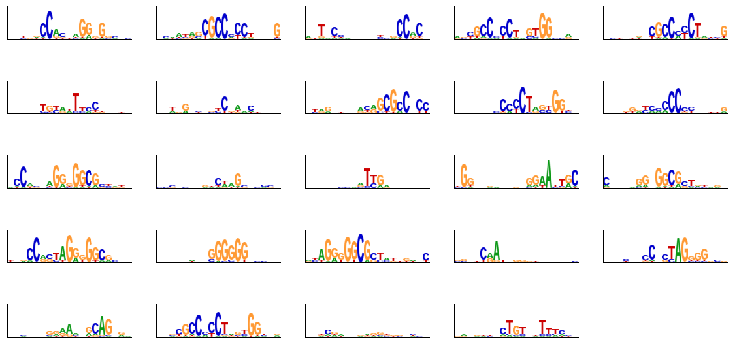

In [8]:
# plot first layer filters
W = nnmodel.get_parameters(sess, layer='conv1d_0')[0]
fig = visualize.plot_filter_logos(W, figsize=(100,50), height=25, 
                            nt_width=10, norm=0, alphabet='dna')

# get predictions

Note: the activations of any layer can be extracted by giving the layer name.

In [9]:
# calculate activations
predictions = nntrainer.get_activations(sess, test, layer='output')

# close session

In [10]:
# close session
sess.close()

# Let's plot saliency maps for the highest predicted sequences

INFO:tensorflow:Restoring parameters from ../results/CTCF/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/CTCF/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/CTCF/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/CTCF/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/CTCF/deepomics_cnn_best.ckpt


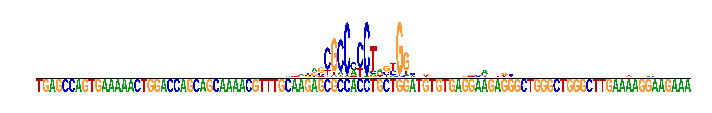

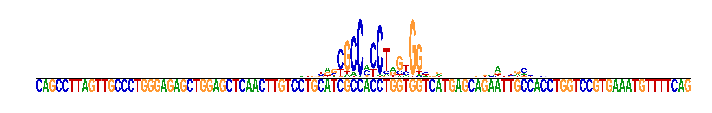

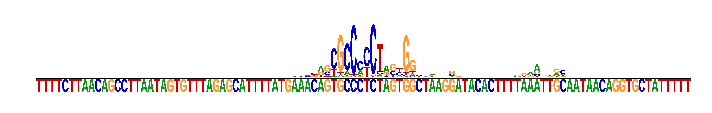

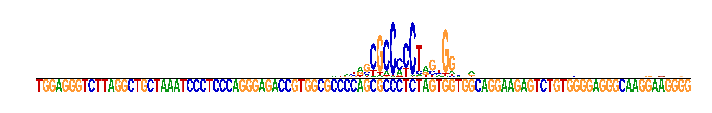

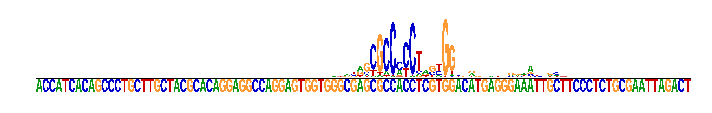

In [11]:
# sort activations
plot_index = np.argsort(predictions[:,0])[::-1]

# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

# plot saliency of top activations
num_plots = 5
for index in plot_index[:num_plots]:

        # get a test sequence
        X = np.expand_dims(test['inputs'][index], axis=0)

        # guided backprop
        guided_saliency = saliency.guided_backprop(X, layer='output', class_index=None, params=params)

        # plot and save saliency
        fig = plt.figure(figsize=(10,10))
        visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                        np.squeeze(guided_saliency[0]).T, 
                                        alphabet='dna', 
                                        nt_width=400)